#**1. Importing packages**

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [2]:
%matplotlib inline

In [3]:
sns.set(color_codes=True)

#**2. Loading data**

In [4]:
train_data = pd.read_csv('https://raw.githubusercontent.com/waldysetio/customer-churn-analysis/main/processed-data/processed_train.csv')
features = pd.read_csv('https://raw.githubusercontent.com/waldysetio/customer-churn-analysis/main/processed-data/features.csv')

Let's merge both dataframes.

In [5]:
train = pd.merge(train_data, features, on="id")

In [6]:
pd.DataFrame({"Dataframe columns": train.columns})

,Dataframe columns
0,id
1,cons_12m
2,cons_gas_12m
3,cons_last_month
4,forecast_cons_12m
5,forecast_discount_energy
6,forecast_meter_rent_12m
7,forecast_price_energy_p1
8,forecast_price_energy_p2
9,forecast_price_pow_p1


#**3. Splitting data**

We will use "churn" as the output or response and the rest columns as the features of our model.

In [7]:
y = train["churn"]
X = train.drop(labels = ["id","churn"], axis = 1)

Next we will split the data into training and validation data. The percentages of each test can be changed but a 75%-25% is a good ratio.
We also use a random state generator in order to split it randomly.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=18)

#**4. Modelling**

In [9]:
model = xgb.XGBClassifier(learning_rate=0.1,max_depth=6,n_estimators=500,n_jobs=-1)
result = model.fit(X_train,y_train)

#**5. Model evaluation**

Let's evaluate our model using the evaluation metrics of:

Accuracy : The most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations.

Precision : The ratio of correctly predicted positive observations to the total predicted positive observations.

Recall (Sensitivity): The ratio of correctly predicted positive observations to the all observations in actual class.

**Accuracy, Precision, Recall**

This is the confusion matrix that shows the predicted values compared to the true values.

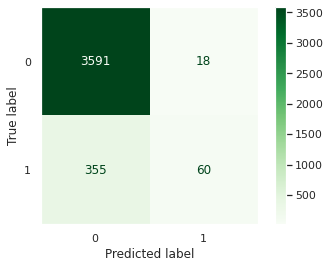

In [10]:
from sklearn.metrics import plot_confusion_matrix

class_names = ['0', '1']
disp = plot_confusion_matrix(result, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Greens,
                                 values_format = '.0f')
plt.grid(False)  
plt.show(disp)



In [11]:
def evaluate(model_, X_test_, y_test_): 

    # Get the model predictions
    prediction_test_ = model_.predict(X_test_)

    # Print the evaluation metrics as pandas dataframe 
    results = pd.DataFrame({"Accuracy" : [metrics.accuracy_score(y_test_, prediction_test_)], 
                            "Precision" : [metrics.precision_score(y_test_, prediction_test_)], 
                            "Recall" : [metrics.recall_score(y_test_, prediction_test_)]})
    return results

In [12]:
evaluate(model, X_test, y_test)

,Accuracy,Precision,Recall
0,0.907306,0.769231,0.144578


**ROC-AUC**

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity
and specificity.

In [15]:
def calculate_roc_auc(model_, X_test_, y_test_):
    """
    Evaluate the roc-auc score
    """
    # Get the model predictions
    # We are using the prediction for the class 1 -> churn
    prediction_test_ = model_.predict_proba(X_test_)[:,1] 
    
    # Compute roc-auc
    fpr, tpr, thresholds = metrics.roc_curve(y_test_, prediction_test_)

    # Print the evaluation metrics as pandas dataframe
    score = pd.DataFrame({"ROC-AUC" : [metrics.auc(fpr, tpr)]}) 
   
    return fpr, tpr, score

In [16]:
def plot_roc_auc(fpr,tpr): 
    """
    Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates.
    """
    # Initialize plot
    f, ax = plt.subplots(figsize=(14,8)) # Plot ROC
    
    # Plot ROC
    roc_auc = metrics.auc(fpr, tpr) 
    ax.plot(fpr, tpr, lw=2, alpha=0.3, label="AUC = %0.2f" % (roc_auc)) 

    # Plot the random line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r', label="Random", alpha=.8)
  
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05]) 
    ax.set_ylim([-0.05, 1.05]) 
    ax.set_xlabel("False Positive Rate (FPR)") 
    ax.set_ylabel("True Positive Rate (TPR)") 
    ax.set_title("ROC-AUC") 
    ax.legend(loc="lower right")
    plt.show()

In [17]:
fpr, tpr, auc_score = calculate_roc_auc(model, X_test, y_test)

In [18]:
auc_score

,ROC-AUC
0,0.684637


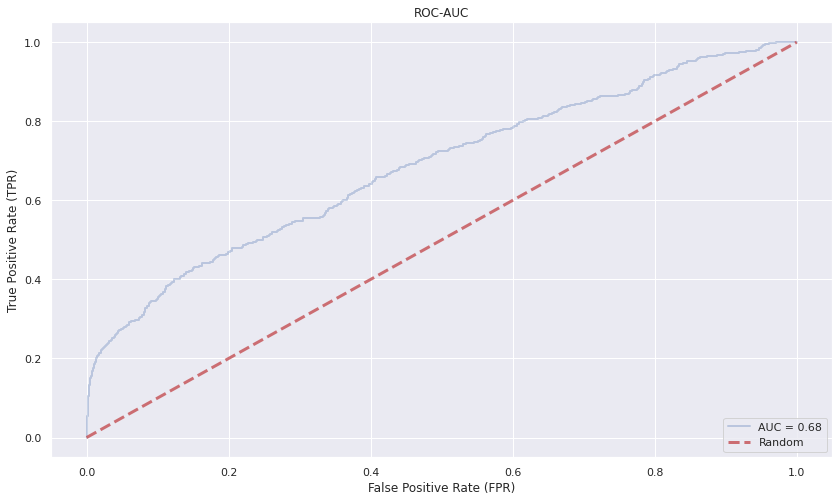

In [19]:
plot_roc_auc(fpr, tpr)
plt.show()

**Stratified K-fold validation**

In [20]:
def plot_roc_curve(fprs, tprs): 
    """ 
    Plot the Receiver Operating Characteristic from a list of true positive rates and false positive rates. 
    """ 
    # Initialize useful lists + the plot axes. 
    tprs_interp = [] 
    aucs = [] 
    mean_fpr = np.linspace(0, 1, 100) 
    f, ax = plt.subplots(figsize=(18,10))
    # Plot ROC for each K-Fold + compute AUC scores. 
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)): 
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr)) 
        tprs_interp[-1][0] = 0.0 
        roc_auc = metrics.auc(fpr, tpr) 
        aucs.append(roc_auc) 
        ax.plot(fpr, tpr, lw=2, alpha=0.3, 
        label="ROC fold %d (AUC = %0.2f)" % (i, roc_auc)) 

    # Plot the luck line. 
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
              label="Random", alpha=.8) 
    
    # Plot the mean ROC. 
    mean_tpr = np.mean(tprs_interp, axis=0) 
    mean_tpr[-1] = 1.0 
    mean_auc = metrics.auc(mean_fpr, mean_tpr) 
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', 
            label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), 
            lw=4, alpha=.8) 
    
    # Plot the standard deviation around the mean ROC. 
    std_tpr = np.std(tprs_interp, axis=0) 
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1) 
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0) 
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.2,
                    label=r"$\pm$ 1 std. dev.")
    
    # Fine tune and show the plot. 
    ax.set_xlim([-0.05, 1.05]) 
    ax.set_ylim([-0.05, 1.05]) 
    ax.set_xlabel("False Positive Rate (FPR)") 
    ax.set_ylabel("True Positive Rate (TPR)") 
    ax.set_title("ROC-AUC") 
    ax.legend(loc="lower right") 
    plt.show() 
    return (f, ax)
def compute_roc_auc(model_, index): 
    y_predict = model_.predict_proba(X.iloc[index])[:,1] 
    fpr, tpr, thresholds = metrics.roc_curve(y.iloc[index], y_predict) 
    auc_score = metrics.auc(fpr, tpr) 
    return fpr, tpr, auc_score

In [21]:
cv = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)
fprs, tprs, scores = [], [], []

In [25]:
for (train, test), i in zip(cv.split(X, y), range(5)): 
    model.fit(X.iloc[train], y.iloc[train]) 
    _, _, auc_score_train = compute_roc_auc(model, train) 
    fpr, tpr, auc_score = compute_roc_auc(model, test) 
    scores.append((auc_score_train, auc_score)) 
    fprs.append(fpr) 
    tprs.append(tpr)

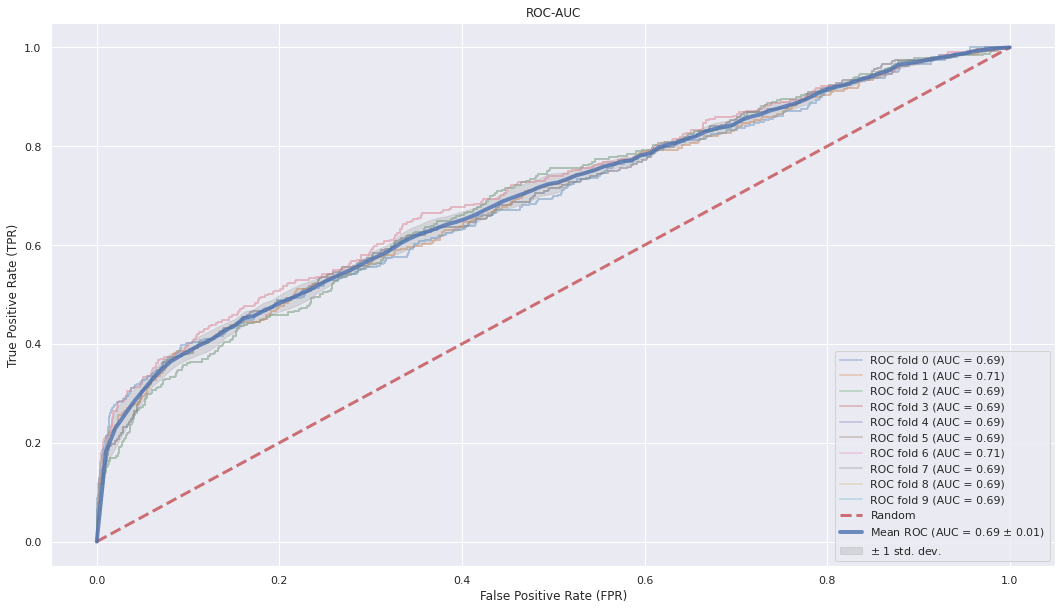

In [26]:
plot_roc_curve(fprs, tprs)
plt.show()

#**6. Model finetuning**

**Random search cross validation**

In [27]:
from sklearn.model_selection import RandomizedSearchCV

In [28]:
# Create the random grid
params = {
        'min_child_weight': [i for i in np.arange(1,15,1)], 
        'gamma': [i for i in np.arange(0,6,0.5)], 
        'subsample': [i for i in np.arange(0,1.1,0.1)], 
        'colsample_bytree': [i for i in np.arange(0,1.1,0.1)], 
        'max_depth': [i for i in np.arange(1,15,1)], 
        'scale_pos_weight':[i for i in np.arange(1,15,1)], 
        'learning_rate': [i for i in np.arange(0,0.15,0.01)], 
        'n_estimators' : [i for i in np.arange(0,2000,100)]}


We will create a new base mode.

In [29]:
xg = xgb.XGBClassifier(objective='binary:logistic', 
                       silent=True, nthread=1)

In [30]:
# Random search of parameters, using 5
xg_random = RandomizedSearchCV(xg, param_distributions=params, 
                               n_iter=1, scoring= "roc_auc", 
                               n_jobs=4, cv=5, verbose=3, random_state=1001)
# Fit the random search model
xg_random.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    6.8s remaining:   10.2s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.3s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=1,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale...
                                        'n_estimators': [0, 100, 200, 300, 400,
                                                         500, 600, 700, 800,
                    

In [31]:
best_random = xg_random.best_params_
best_random = {'subsample': 0.8,
  'scale_pos_weight': 1, 
  'n_estimators': 1100, 
  'min_child_weight': 1, 
  'max_depth': 12, 
  'learning_rate': 0.01, 
  'gamma': 4.0, 
  'colsample_bytree': 0.60}


In [32]:
# Create a model with the parameters found
model_random = xgb.XGBClassifier(objective='binary:logistic', 
                        silent=True, nthread=1, **best_random)
fprs, tprs, scores = [], [], []

In [33]:
for (train, test), i in zip(cv.split(X, y), range(5)): 
    model_random.fit(X.iloc[train], y.iloc[train]) 
    _, _, auc_score_train = compute_roc_auc(model_random, train) 
    fpr, tpr, auc_score = compute_roc_auc(model_random, test) 
    scores.append((auc_score_train, auc_score)) 
    fprs.append(fpr) 
    tprs.append(tpr)


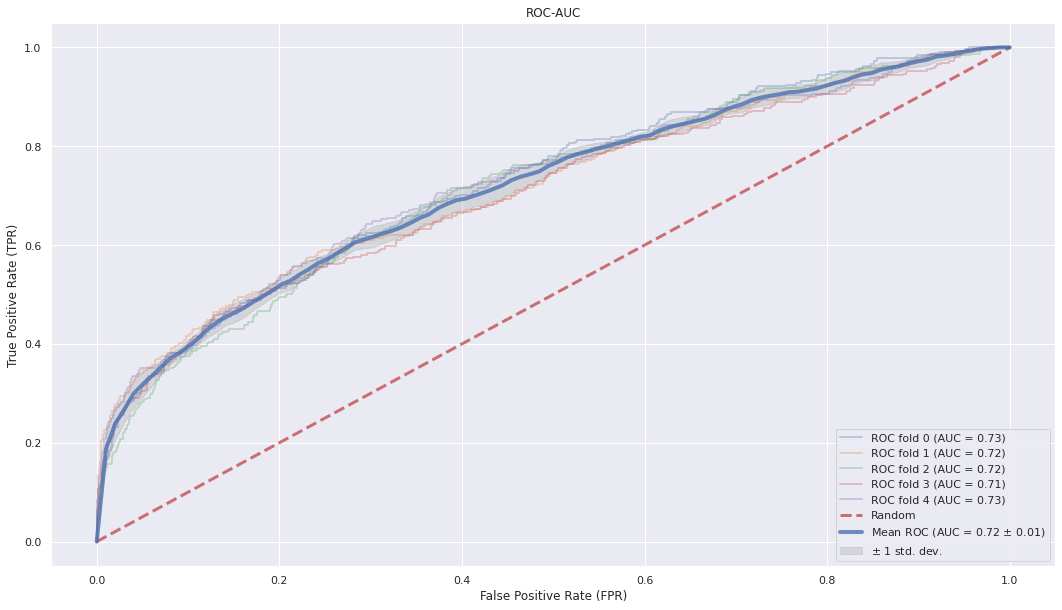

In [34]:
plot_roc_curve(fprs,tprs)
plt.show()

**Grid search with cross validation (calculating over weekend, then make smaller)**

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
# Create the parameter grid based on the results of random search 
param_grid = {'subsample': [0.7],
              'scale_pos_weight': [1], 
              'n_estimators': [1100], 
              'min_child_weight': [1], 
              'max_depth': [12, 13, 14], 
              'learning_rate': [0.005, 0.01], 
              'gamma': [4.0], 
              'colsample_bytree': [0.6]}


In [37]:
# Create model
xg = xgb.XGBClassifier(objective='binary:logistic', 
                       silent=True, nthread=1)

In [38]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xg, param_grid = param_grid, 
                            cv = 5, n_jobs = -1, verbose = 2, scoring = "roc_auc")

In [39]:
# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 23.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=1, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_w...ed=None, silent=True,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.6], 'gamma': [4.0],
                         'learning_rate': [0.005, 0.01],
                         'max_depth': [12, 13, 14], 'min_child_we

In [40]:
best_grid = grid_search.best_params_
best_grid

{'colsample_bytree': 0.6,
 'gamma': 4.0,
 'learning_rate': 0.005,
 'max_depth': 12,
 'min_child_weight': 1,
 'n_estimators': 1100,
 'scale_pos_weight': 1,
 'subsample': 0.7}

In [41]:
# Create a model with the parameters found
model_grid = xgb.XGBClassifier(objective='binary:logistic', 
                               silent=True, nthread=1, **best_grid)
fprs, tprs, scores = [], [], []


In [42]:
for (train, test), i in zip(cv.split(X, y), range(5)):
    model_grid.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(model_grid, train)
    fpr, tpr, auc_score = compute_roc_auc(model_grid, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

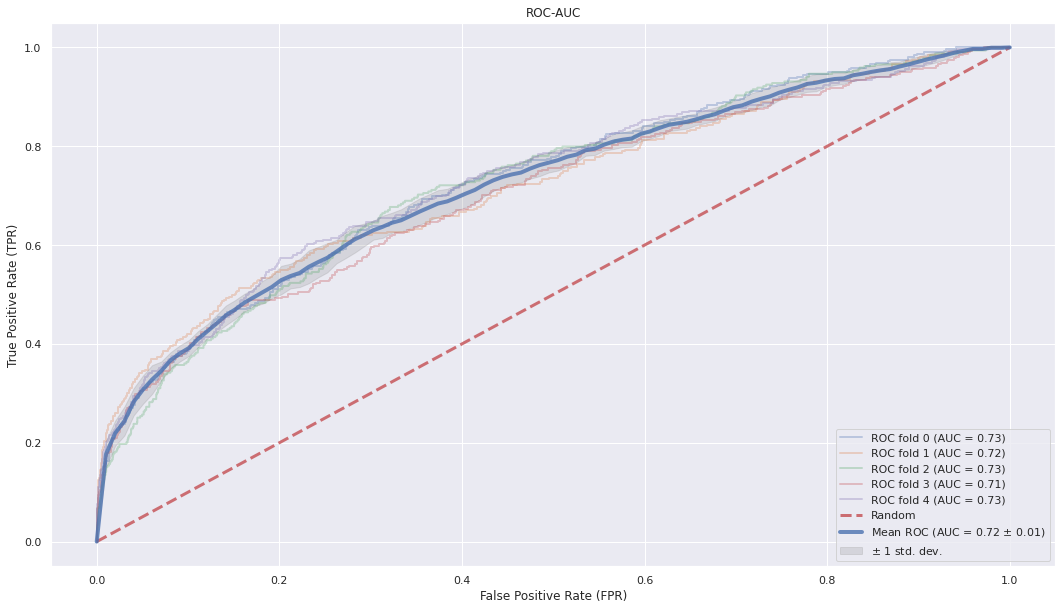

In [43]:
plot_roc_curve(fprs, tprs)
plt.show()

#**7. Understanding the model**


**Feature importance**

One simple way of boserving the feature importance is through counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear.

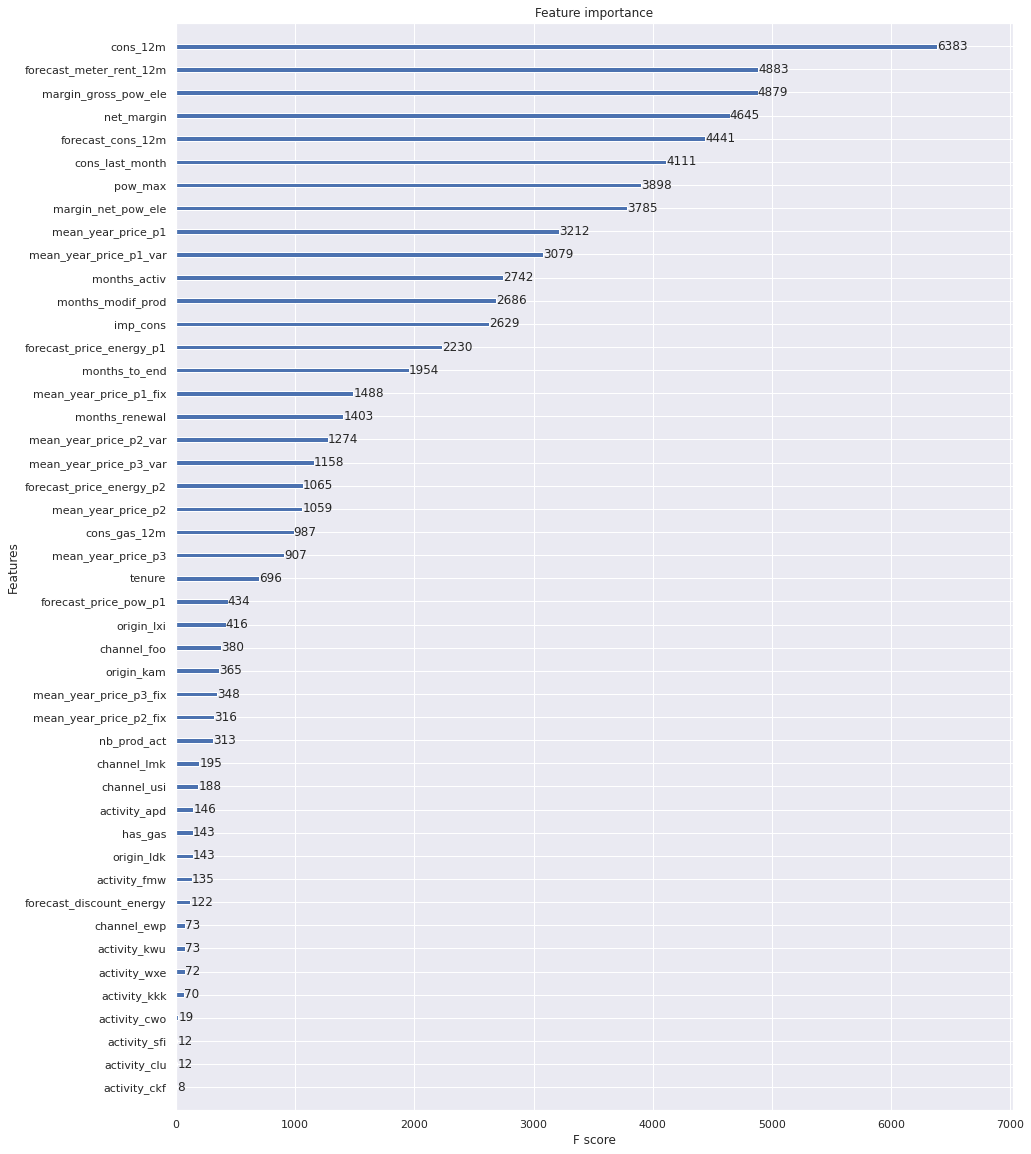

In [44]:
fig, ax = plt.subplots(figsize=(15,20))
xgb.plot_importance(model_grid, ax=ax)

In the feature importance graph above we can see that cons_12m and some other are the features that appear the most in our model and we could infere that these two features have a significant importnace in our model.

**Partial dependence plot**

In [45]:
from sklearn.inspection import plot_partial_dependence

In [46]:
# Create a model with the parameters found
model_grid_v2 = xgb.XGBClassifier(objective='binary:logistic',
                                  silent=True, nthread=1, **best_grid)
model_grid_v2.fit(X_train.values,y_train.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=4.0,
              learning_rate=0.005, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=1100, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.7, verbosity=1)

/usr/local/lib/python3.7/dist-packages/sklearn/inspection/_partial_dependence.py:715: FutureWarning: The fig parameter is deprecated in version 0.22 and will be removed in version 0.24
  FutureWarning)


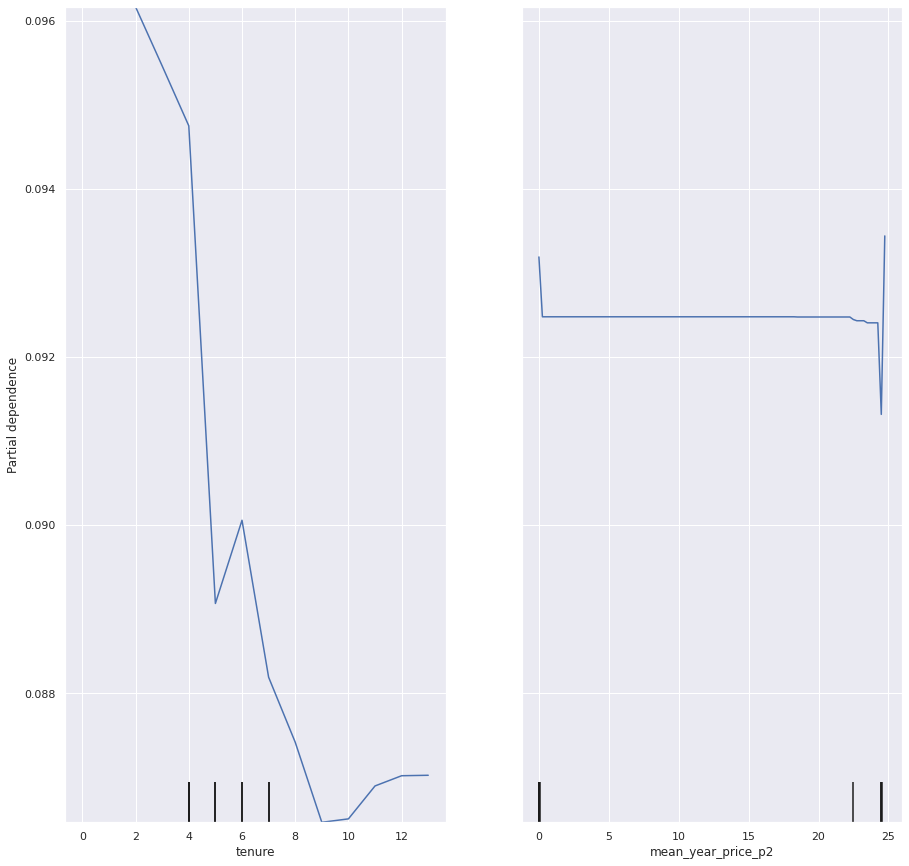

In [47]:
fig = plt.figure(figsize=(15,15))
plot_partial_dependence(model_grid_v2, X_test.values, features=[16, 49], 
                        feature_names=X_test.columns.tolist(), fig=fig)

tenure

The overall trend is unchaged as compared to our previous models. We can see the trend spikes at slighly different times of the tenure ( 6y ) but then it goes down again and bottoms around 10 years. Then, it starts recovering a bit.

mean_year_price_p2

In our previous models, we saw a sort of "stairshape", in this case we see the pdp is almost flat with some spikes on the extreme values, which hints us that the variable mean_year_price_p2 is not very relevant in this model.